<a href="https://colab.research.google.com/github/20wh1a05d0/Machine-Learning-Project/blob/main/Youtube_category_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**READING THE DATA**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from sklearn.ensemble import RandomForestClassifier
from nltk.stem import PorterStemmer
import nltk

In [4]:
data = pd.read_csv('Youtube Video Dataset.csv')

In [5]:
data.head(10)

,Title,Videourl,Category,Description
0,Madagascar Street Food!!! Super RARE Malagasy ...,/watch?v=EwBA1fOQ96c,Food,🎥GIANT ALIEN SNAIL IN JAPAN! » https://youtu.b...
1,42 Foods You Need To Eat Before You Die,/watch?v=0SPwwpruGIA,Food,This is the ultimate must-try food bucket list...
2,Gordon Ramsay’s Top 5 Indian Dishes,/watch?v=upfu5nQB2ks,Food,We found 5 of the best and most interesting In...
3,How To Use Chopsticks - In About A Minute 🍜,/watch?v=xFRzzSF_6gk,Food,You're most likely sitting in a restaurant wit...
4,Trying Indian Food 1st Time!,/watch?v=K79bXtaRwcM,Food,HELP SUPPORT SINSTV!! Shop Our Sponsors!\nLast...
5,Blippi Tours the Chocolate Factory | Learn abo...,/watch?v=uSIb-Wbyx6Y,Food,After Blippi eats his vegetables Blippi takes ...
6,EGYPT: Vegetarian food | Mobile Sim | Indian S...,/watch?v=Gozaqmg6hmk,Food,"http://bit.ly/subscribeMT\nIn this video, you ..."
7,Chinese Street Food Liuhe Tourist Night Market,/watch?v=H0xKYgUX3zI,Food,Trying many different kinds of chinese street ...
8,India's Biggest food FESTIVAL | food truck fes...,/watch?v=NpOVNb1keoc,Food,Alright guys i hope you liked my video.\nAbout...
9,Street Food in Madagascar's Biggest City!!! Ze...,/watch?v=OXHHNBVt0pw,Food,🎥VILLAGE FOOD IN MADAGASCAR! » https://youtu.b...


In [6]:
print(data.shape)
print(data.isnull().values.any())

(11211, 4)
True


In [7]:
data=data.dropna()
print(data.isnull().values.any())

False


In [8]:
Category=data['Category'].value_counts()
print(Category.shape)
print(Category)
#value_count gives the count of unique values in each column

(6,)
travel blog           2200
Science&Technology    2074
Food                  1828
manufacturing         1699
Art&Music             1682
History               1645
Name: Category, dtype: int64


**Preprocessing of data**

In [9]:
# loading stop words from nltk library
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
#Stemmering the word
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        #Removing link - If any occurence in the form of the below mentioned line (url_pattern), it will be removed
        url_pattern = r'((http|ftp|https):\/\/)?[\w\-_]+(\.[\w\-_]+)+([\w\-\.,@?^=%&amp;:/~\+#]*[\w\-\@?^=%&amp;/~\+#])?'
        total_text = re.sub(url_pattern, ' ', total_text)
        #re.sub(pattern to be removed, replacement, string)
        #removing email address
        email_pattern =r'[a-z0-9\.\-+_]+@[a-z0-9\.\-+_]+\.[a-z]+'
        total_text = re.sub(email_pattern, ' ', total_text)
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case - improves classification, helps to get rid of unhelpful parts of the data, or noise.
        #and we do not want Laptop, LAPTOP and laptop to be seen as different strings
        total_text = total_text.lower()

        #.split() - is used to split a string into a list where each word is a list item
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                word=(sno.stem(word))
                string += word + " "

        data[column][index] = string

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
#text processing stage.
import time
start_time = time.perf_counter()
for index, row in data.iterrows():
    if type(row['Description']) is str:
        preprocessing(row['Description'], index, 'Description')
print('Time took for preprocessing the text :',time.perf_counter() - start_time, "seconds")

Time took for preprocessing the text : 26.030812105999985 seconds


In [11]:
data.head(10)

,Title,Videourl,Category,Description
0,Madagascar Street Food!!! Super RARE Malagasy ...,/watch?v=EwBA1fOQ96c,Food,giant alien snail japan go tour madagascar get...
1,42 Foods You Need To Eat Before You Die,/watch?v=0SPwwpruGIA,Food,ultim must tri food bucket list burger dip che...
2,Gordon Ramsay’s Top 5 Indian Dishes,/watch?v=upfu5nQB2ks,Food,found 5 best interest indian recip channel inc...
3,How To Use Chopsticks - In About A Minute 🍜,/watch?v=xFRzzSF_6gk,Food,like sit restaur set chopstick hand say video ...
4,Trying Indian Food 1st Time!,/watch?v=K79bXtaRwcM,Food,help support sinstv shop sponsor last longer b...
5,Blippi Tours the Chocolate Factory | Learn abo...,/watch?v=uSIb-Wbyx6Y,Food,blippi eat veget blippi take tour chocol facto...
6,EGYPT: Vegetarian food | Mobile Sim | Indian S...,/watch?v=Gozaqmg6hmk,Food,video see hunt best mobil network egypt base f...
7,Chinese Street Food Liuhe Tourist Night Market,/watch?v=H0xKYgUX3zI,Food,tri mani differ kind chines street food liuh t...
8,India's Biggest food FESTIVAL | food truck fes...,/watch?v=NpOVNb1keoc,Food,alright guy hope like video aim find somewhat ...
9,Street Food in Madagascar's Biggest City!!! Ze...,/watch?v=OXHHNBVt0pw,Food,villag food madagascar go tour madagascar get ...


**Test, Train and Cross Validation Split**                                
We are splitting the data into train, validation and test dataset

Here, we are splitting the category column for training, testing and cross-validation datasets. And then we are finding the count of data points of each category in trainin, testing and validation dataset.

In [12]:
y_true = data['Category'].values
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.2)
#It is splitting the given data into testing set
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)
#It is splitting the given data into training set

In [13]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cv data:', cv_df.shape[0])

Number of data points in train data: 7121
Number of data points in test data: 2226
Number of data points in cv data: 1781


In [14]:
X_trainCategory=train_df['Category'].value_counts()
print(X_trainCategory)

travel blog           1408
Science&Technology    1327
Food                  1169
manufacturing         1087
Art&Music             1077
History               1053
Name: Category, dtype: int64


In [15]:
X_trainCategory.values
#It gives the array of count in each category

array([1408, 1327, 1169, 1087, 1077, 1053])

In [16]:
X_trainCategory.index

#In X_trainCategory, the x-axis have the category and y-axis gives the count of each category in training set

Index(['travel blog', 'Science&Technology', 'Food', 'manufacturing',
       'Art&Music', 'History'],
      dtype='object')

Distribution of y in train


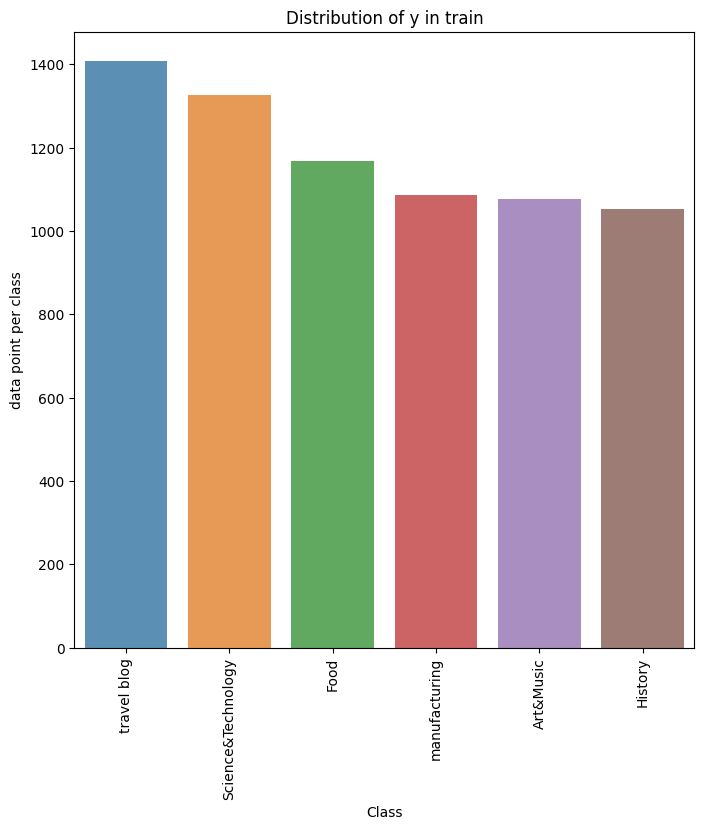

travel blog           440
Science&Technology    415
Food                  366
manufacturing         340
Art&Music             336
History               329
Name: Category, dtype: int64
Distribution of y in test


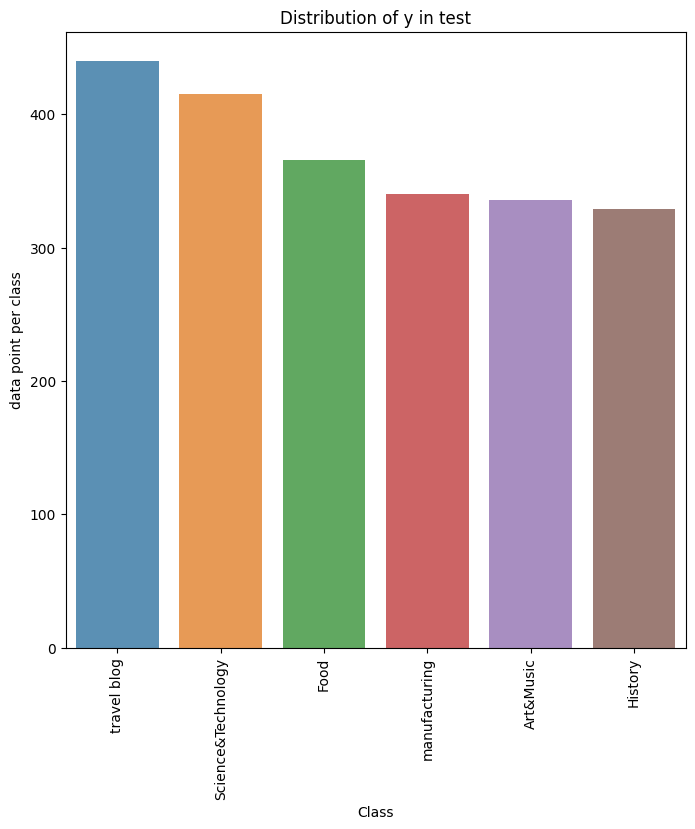

travel blog           352
Science&Technology    332
Food                  293
manufacturing         272
Art&Music             269
History               263
Name: Category, dtype: int64
Distribution of y in cv


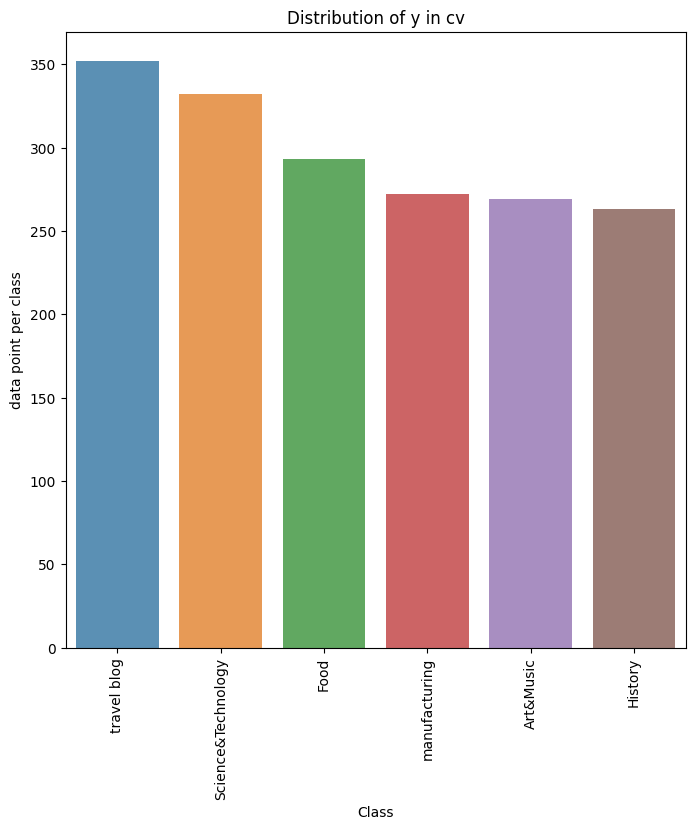

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
print('Distribution of y in train')
X_trainCategory=train_df['Category'].value_counts()
plt.figure(figsize=(8,8))
sns.barplot(x = X_trainCategory.index, y = X_trainCategory.values, alpha=0.8)
plt.title('Distribution of y in train')
plt.ylabel('data point per class')
plt.xlabel('Class')
plt.xticks(rotation=90)
plt.show()

test_dfCategory=test_df['Category'].value_counts()
print(test_dfCategory)
print('Distribution of y in test')
plt.figure(figsize=(8,8))
sns.barplot(x = test_dfCategory.index,y = test_dfCategory.values, alpha=0.8)
plt.title('Distribution of y in test')
plt.ylabel('data point per class')
plt.xlabel('Class')
plt.xticks(rotation=90)
plt.show()

cv_dfCategory=cv_df['Category'].value_counts()
print(cv_dfCategory)
print('Distribution of y in cv')
plt.figure(figsize=(8,8))
sns.barplot(x = cv_dfCategory.index,y = cv_dfCategory.values, alpha=0.8)
plt.title('Distribution of y in cv')
plt.ylabel('data point per class')
plt.xlabel('Class')
plt.xticks(rotation=90)
plt.show()

# New Section

**Text vectorization [BOW,TF-IDF]**

In [18]:
x_tr=train_df['Description']
#x_tr consists of Description data of all rows in training set
x_test=test_df['Description']
#x_test consists of Description data of all rows in testing set
x_cv=cv_df['Description']
#x_cv consists of Description data of all rows in validation set

**(I) LINEAR SVM**

In [19]:
#Bag of words
# CountVectorizer - convert text to numerical data.
bow = CountVectorizer()
x_tr_uni = bow.fit_transform(x_tr)
x_test_uni= bow.transform(x_test)
x_cv_uni= bow.transform(x_cv)

In [20]:
#TF-IDF
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
x_tr_tfidf = tf_idf_vect.fit_transform(x_tr)
x_test_tfidf = tf_idf_vect.transform(x_test)
x_cv_tfidf = tf_idf_vect.transform(x_cv)

In [21]:
def plotPrecisionRecall(y_test,y_pred):
    C = confusion_matrix(y_test, y_pred)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    labels = ['Art&Music','Food','History','Sci&Tech','Manu','TravelBlog']


    print("-"*20, "Precision matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True,annot_kws={"size": 16}, fmt='g', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    # representing B in heatmap format
    print("-"*20, "Recall matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True,annot_kws={"size": 16}, fmt='g', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

##### BOW - Linear SVM

Accuracy on test set: 90.431%
Precision on test set: 0.906
Recall on test set: 0.903
F1-Score on test set: 0.904
---------- confusion matrix ----------


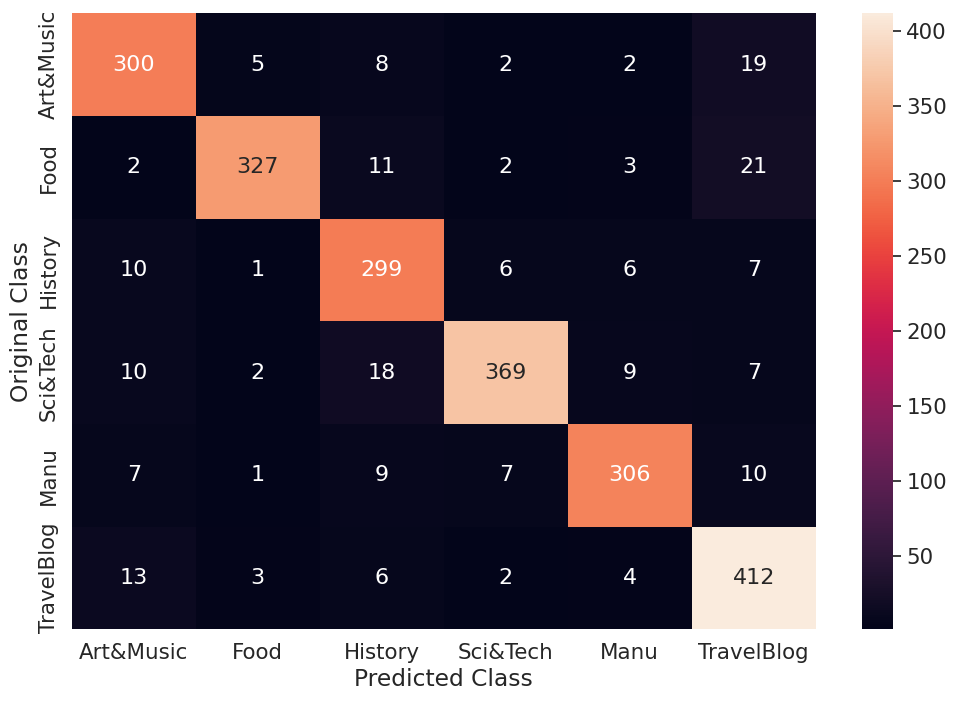

-------------------- Precision matrix --------------------


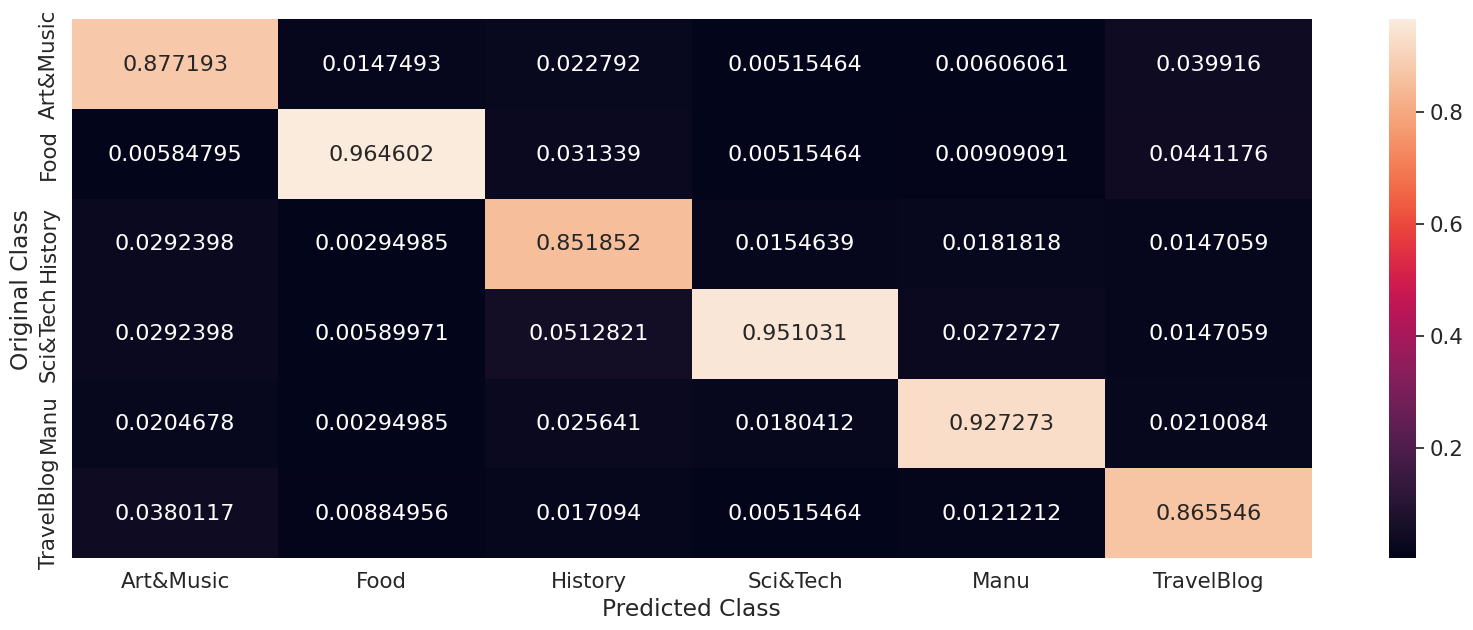

-------------------- Recall matrix --------------------


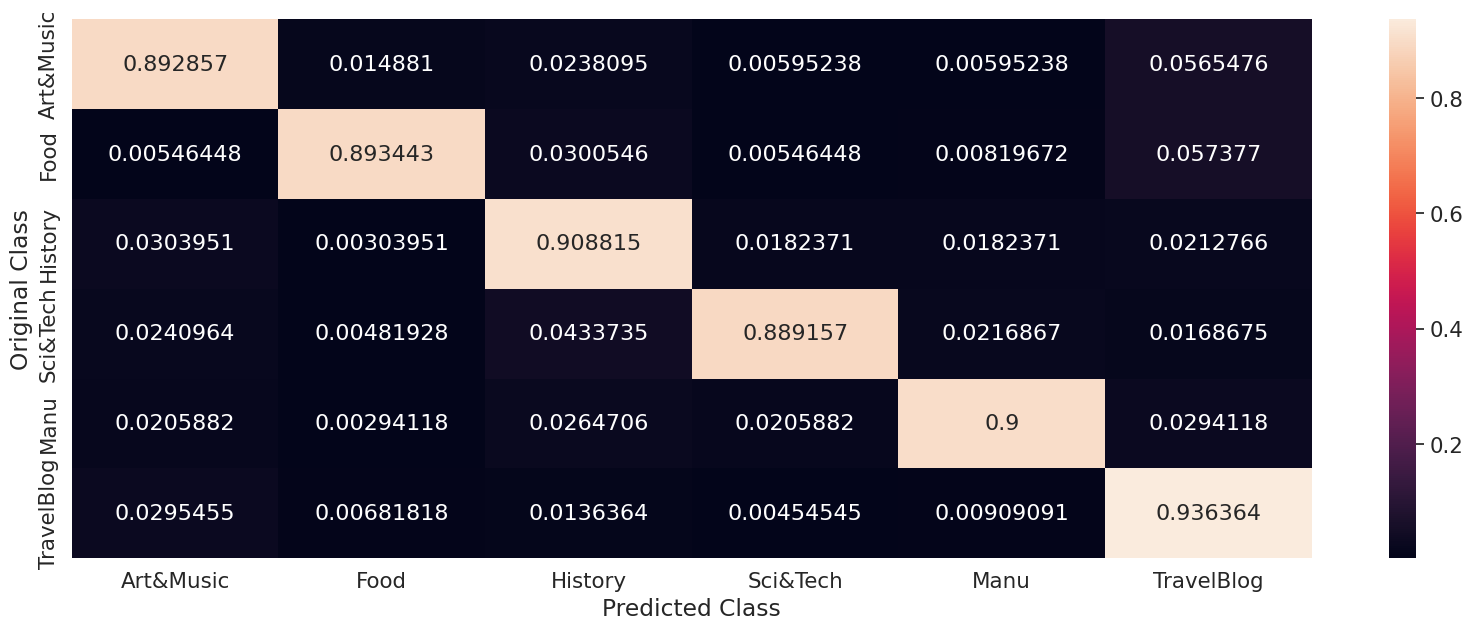

In [22]:
clf = SGDClassifier(loss = 'hinge', alpha = 0.01, class_weight='balanced', learning_rate='optimal',eta0=0.001, n_jobs = -1)
clf.fit(x_tr_uni,y_train)
y_pred = clf.predict(x_test_uni)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))

print("-"*10, "confusion matrix", "-"*10)
plt.figure(figsize=(12,8))
matrix=confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(matrix)
sns.set(font_scale=1.4)#for label size
labels = ['Art&Music','Food','History','Sci&Tech','Manu','TravelBlog']
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g',xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()
plotPrecisionRecall(y_test,y_pred)

**PREDICTION**

data.drop_duplicates(inplace=True)
title = input("Enter the title of the video: ")
description = input("Enter the description of the video: ")
text = title + ' ' + description
X = bow.transform([text])
category = clf.predict(X)[0]
print("The predicted category of the video is:", category)

In [23]:
data.drop_duplicates(inplace=True)

In [24]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 52.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.4/288.4 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.0/137.0 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 15.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mdit-py-plugins to determine which version is compatible with other requirements. This could take a while.
  

In [25]:
def predict_youtube_category(title,description):
  text = title + ' ' + description
  X = bow.transform([text])
  category = clf.predict(X)[0]
  #print("The predicted category of the video is:", category)
  return category

In [26]:
import gradio as gr
#title = input("Enter title: ")
#description = input("Enter description: ")
#input_text = gr.inputs.Textbox(label='Input Title')
input_text = [gr.inputs.Textbox(label='Input Title'),gr.inputs.Textbox(label='Input Description')]
output_text = gr.outputs.Textbox(label='Predicted Category')
interface = gr.Interface(fn=predict_youtube_category, inputs=input_text, outputs=output_text)

# Launch the interface
interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://6edc4b54803b58b34c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


**CONFUSION MATRIX**

A confusion matrix is a table used to evaluate the performance of a classification model by comparing the predicted class labels with the true class labels of a set of test data. The confusion matrix provides a summary of the number of correct and incorrect predictions for each class.

[TP FP
FN TN]

A typical confusion matrix has four entries, corresponding to four possible outcomes:

True Positive (TP): the number of instances that are actually positive (belonging to the positive class) and are correctly predicted as positive by the model.

False Positive (FP): the number of instances that are actually negative (belonging to the negative class) but are incorrectly predicted as positive by the model.

True Negative (TN): the number of instances that are actually negative and are correctly predicted as negative by the model.

False Negative (FN): the number of instances that are actually positive but are incorrectly predicted as negative by the model.

accuracy is the proportion of correct predictions out of the total number of predictions Precision = TP / (TP + FP) Recall = TP / (TP + FN)

#### TF-IDF with Linear-SVM

Accuracy on test set: 91.824%
Precision on test set: 0.918
Recall on test set: 0.918
F1-Score on test set: 0.918
-------------------- confusion matrix --------------------


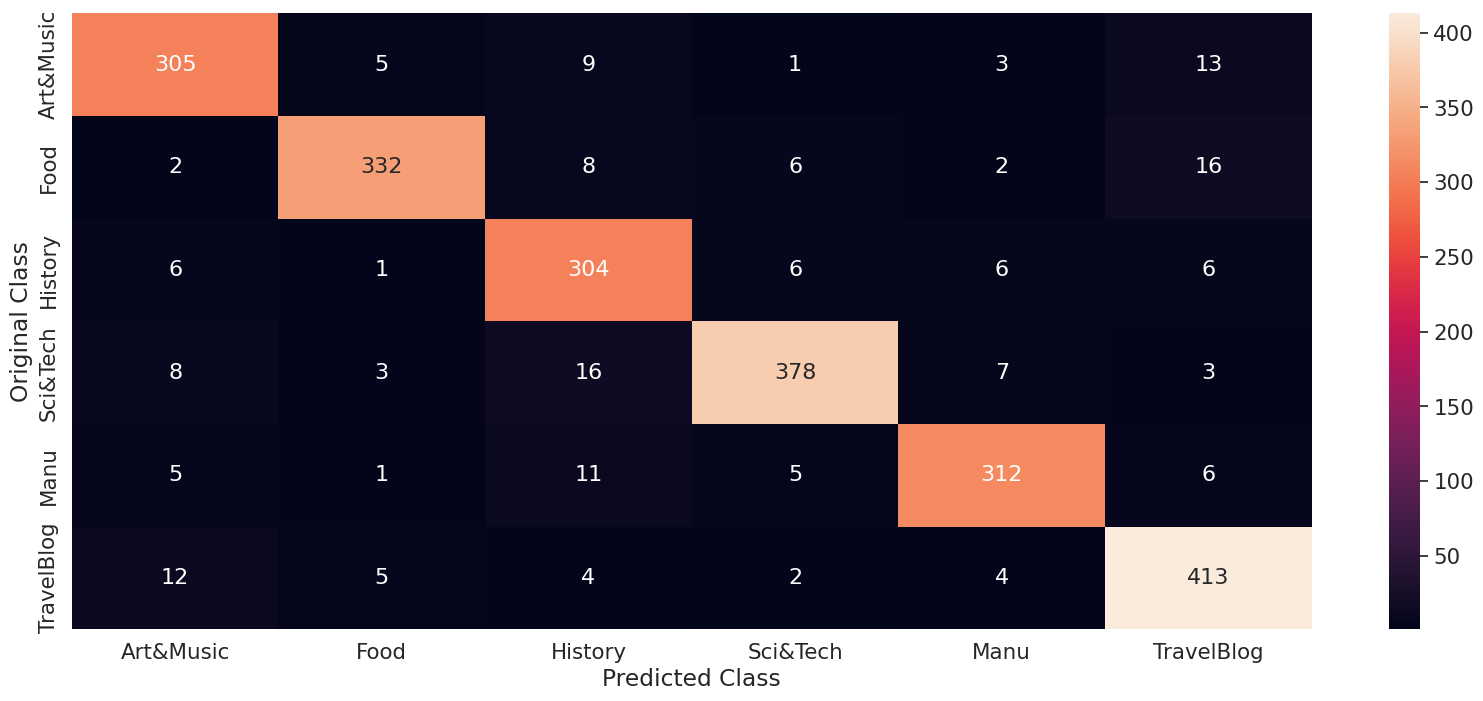

-------------------- Precision matrix --------------------


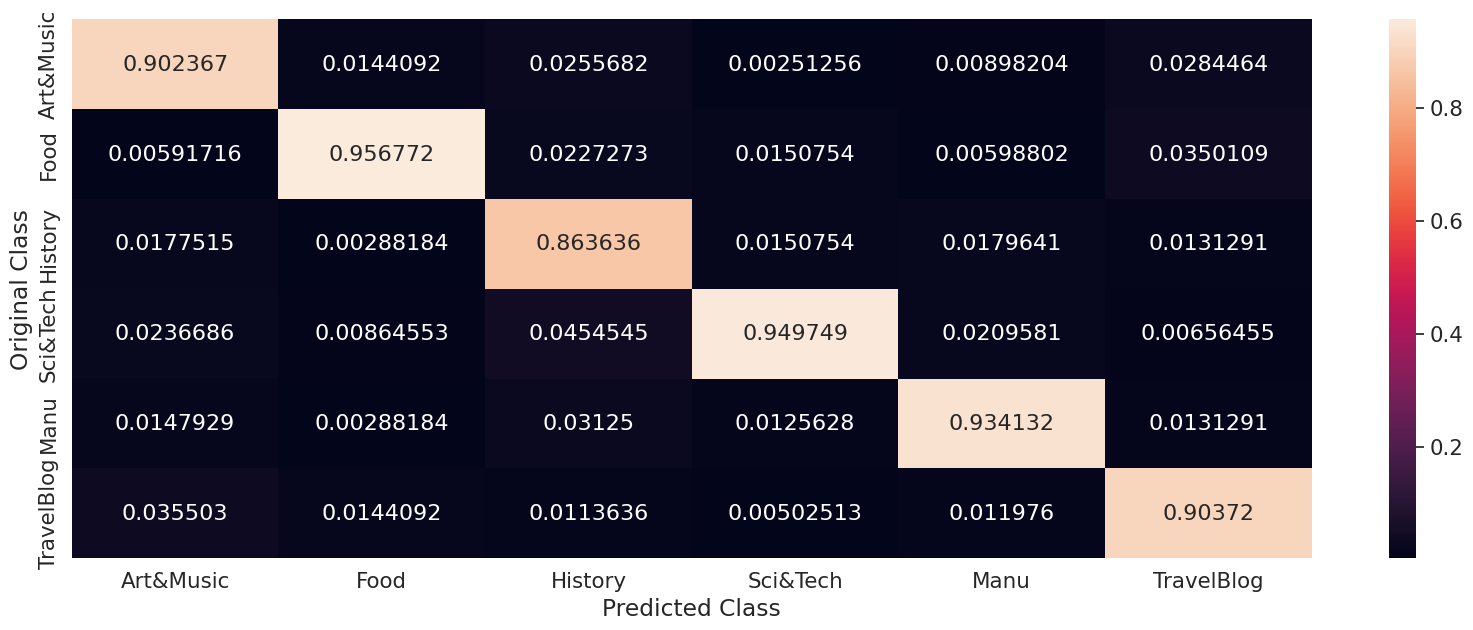

-------------------- Recall matrix --------------------


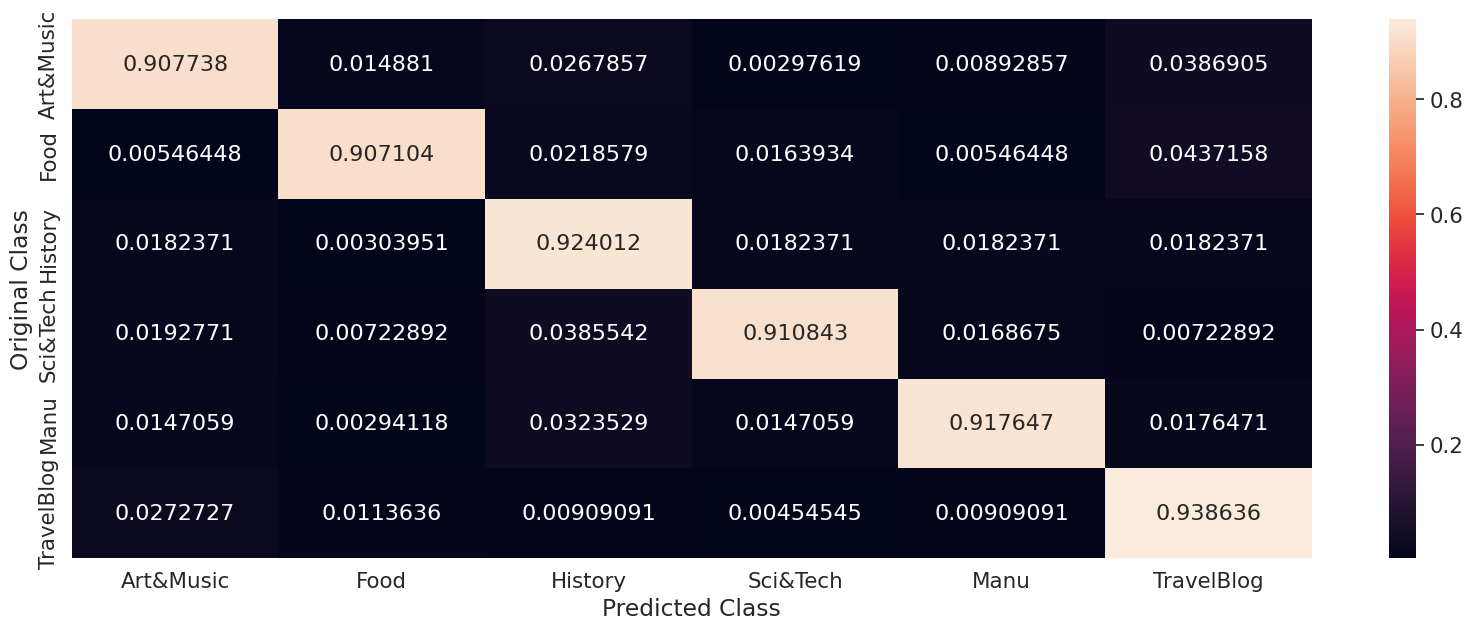

In [27]:
clf = SGDClassifier(loss = 'hinge', alpha =0.0001, class_weight='balanced', learning_rate='optimal',eta0=0.001, n_jobs = -1)
clf.fit(x_tr_tfidf,y_train)
y_pred = clf.predict(x_test_tfidf)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))

print("-"*20, "confusion matrix", "-"*20)
plt.figure(figsize=(20,8))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(6),range(6))
sns.set(font_scale=1.4)#for label size
labels = ['Art&Music','Food','History','Sci&Tech','Manu','TravelBlog']
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g',xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()
plotPrecisionRecall(y_test,y_pred)

**(II)Bagging(Random Forest)**

In [28]:
bow = CountVectorizer()
x_tr_uni = bow.fit_transform(x_tr)
x_test_uni= bow.transform(x_test)

In [29]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
x_tr_tfidf = tf_idf_vect.fit_transform(x_tr)
x_test_tfidf = tf_idf_vect.transform(x_test)

BOW - Random Forest

Accuracy on test set: 86.613%
Precision on test set: 0.865
Recall on test set: 0.865
F1-Score on test set: 0.864
-------------------- confusion matrix --------------------


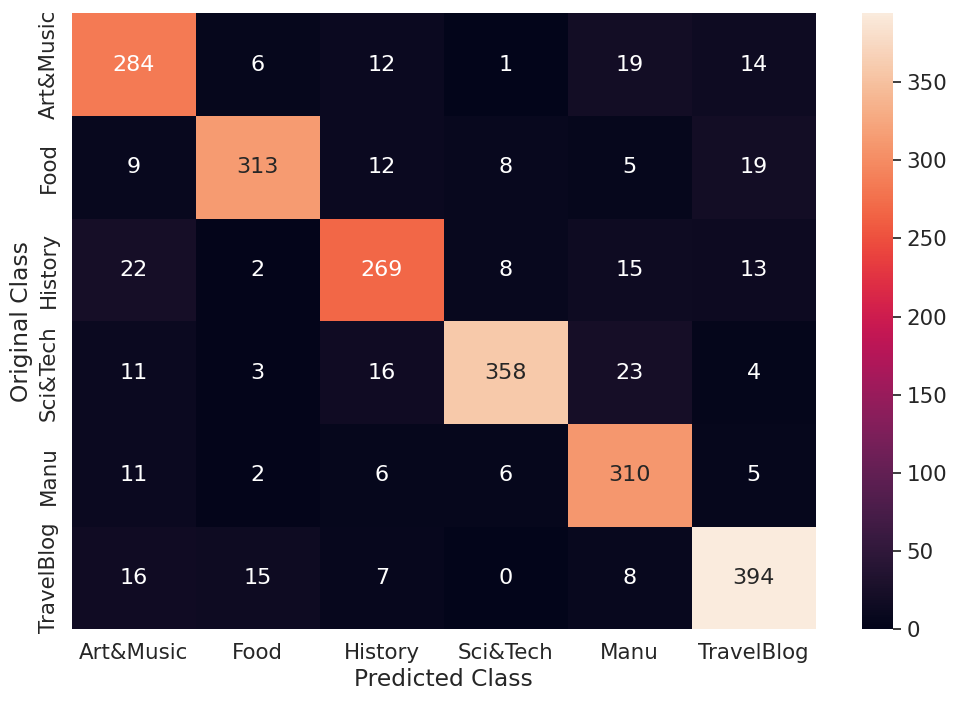

-------------------- Precision matrix --------------------


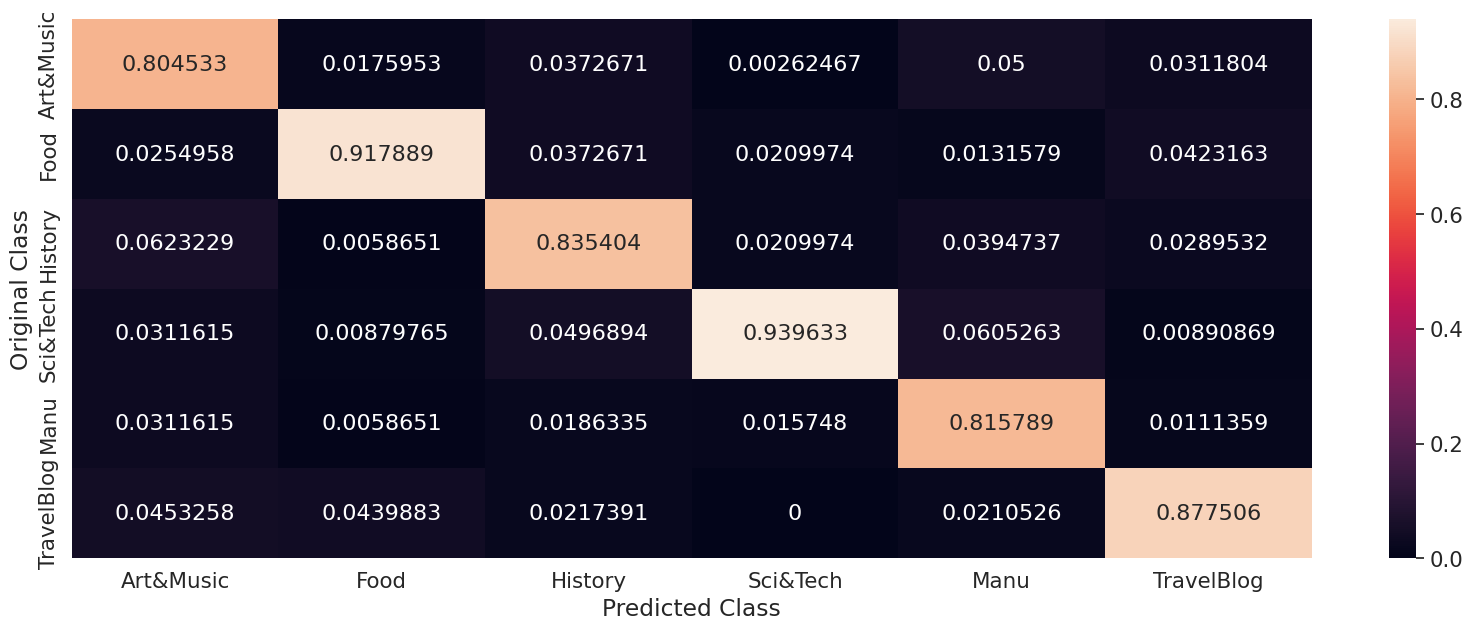

-------------------- Recall matrix --------------------


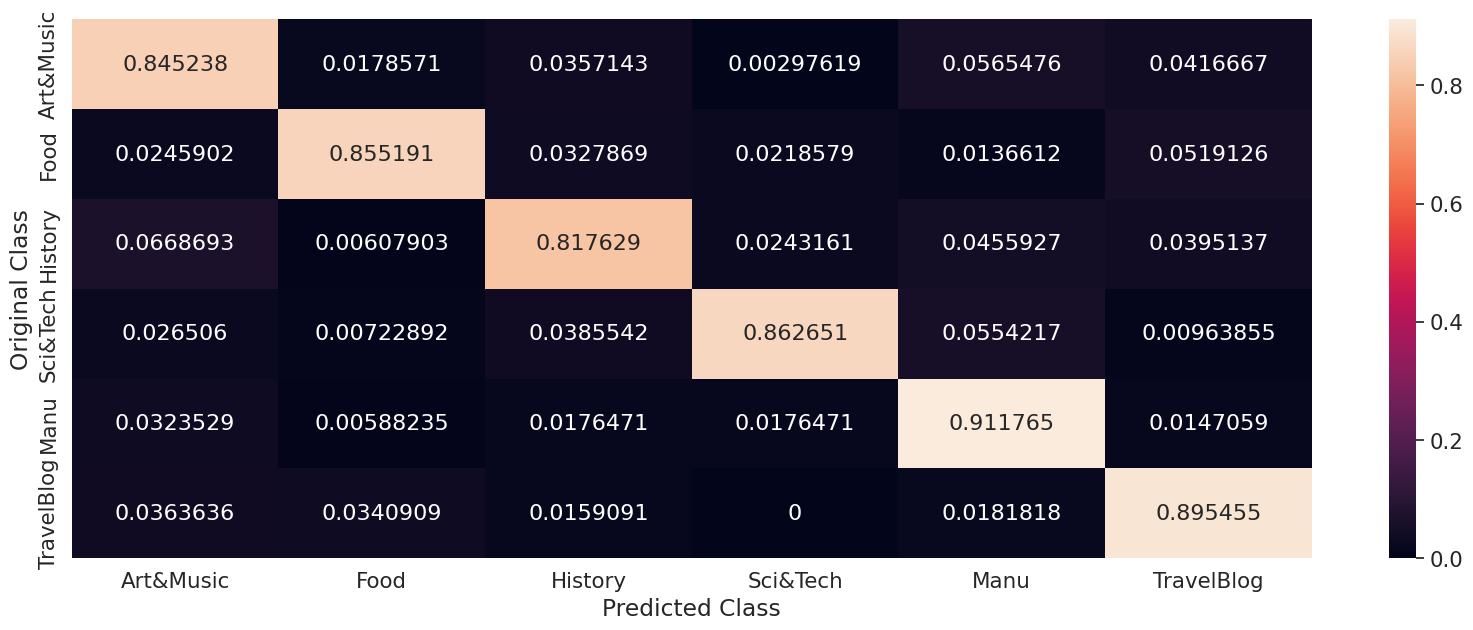

In [30]:
RF= RandomForestClassifier(n_estimators=16,max_depth=130)
RF.fit(x_tr_uni,y_train)
y_pred =RF.predict(x_test_uni)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
print("-"*20, "confusion matrix", "-"*20)
plt.figure(figsize=(12,8))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(6),range(6))
sns.set(font_scale=1.4)#for label size
labels = ['Art&Music','Food','History','Sci&Tech','Manu','TravelBlog']
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g',xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()
plotPrecisionRecall(y_test,y_pred)

TF-IDF - Random Forest



Accuracy on test set: 87.107%
Precision on test set: 0.872
Recall on test set: 0.868
F1-Score on test set: 0.869
-------------------- confusion matrix --------------------


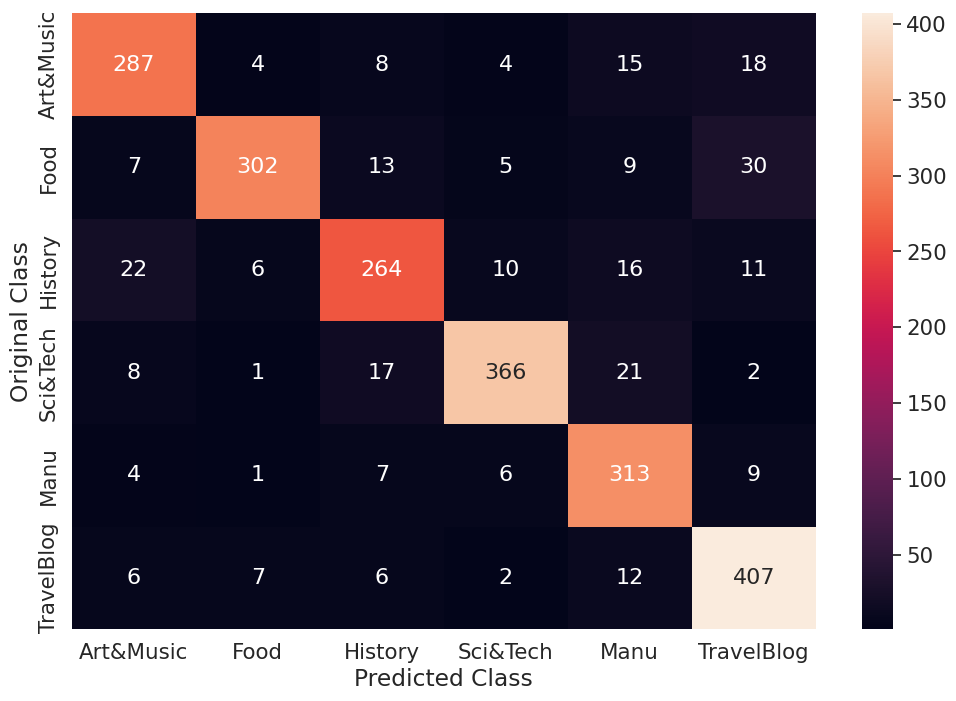

-------------------- Precision matrix --------------------


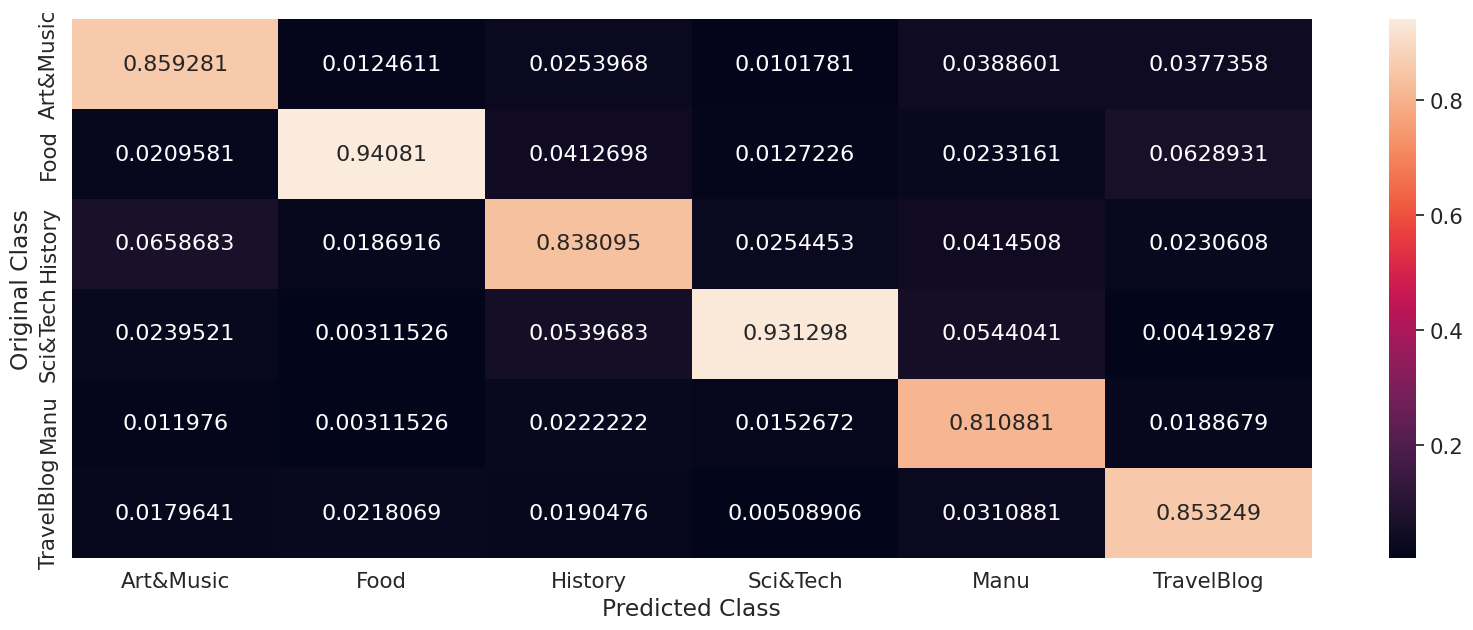

-------------------- Recall matrix --------------------


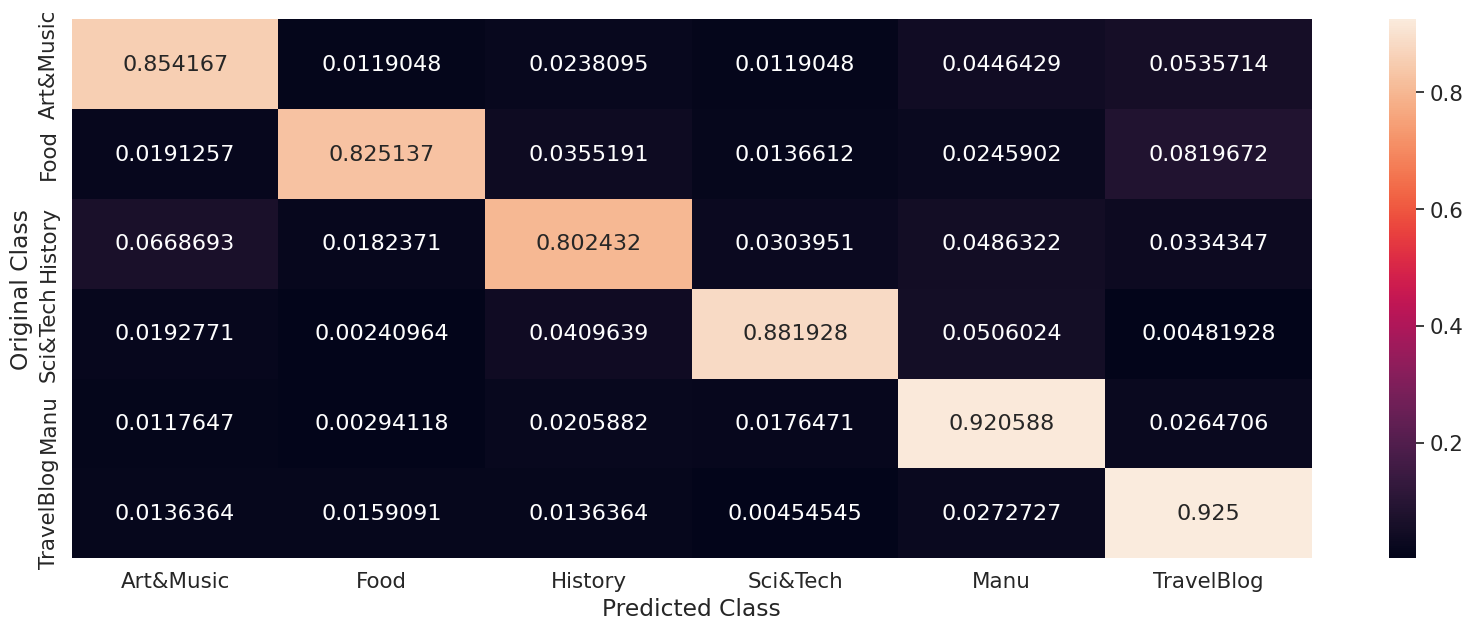

In [31]:
RF= RandomForestClassifier(n_estimators=20,max_depth=190)
RF.fit(x_tr_tfidf,y_train)
y_pred =RF.predict(x_test_tfidf)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
print("-"*20, "confusion matrix", "-"*20)
plt.figure(figsize=(12,8))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(6),range(6))
sns.set(font_scale=1.4)#for label size
labels = ['Art&Music','Food','History','Sci&Tech','Manu','TravelBlog']
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g',xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

plotPrecisionRecall(y_test,y_pred)

**(III) Logistic Regression**

In [32]:
bow = CountVectorizer()
x_tr_uni = bow.fit_transform(x_tr)
x_test_uni= bow.transform(x_test)
x_cv_uni= bow.transform(x_cv)

In [33]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
x_tr_tfidf = tf_idf_vect.fit_transform(x_tr)
x_test_tfidf = tf_idf_vect.transform(x_test)
x_cv_tfidf = tf_idf_vect.transform(x_cv)

BOW - Logistic Regression

Accuracy on test set: 89.937%
Precision on test set: 0.900
Recall on test set: 0.899
F1-Score on test set: 0.899
-------------------- confusion matrix --------------------


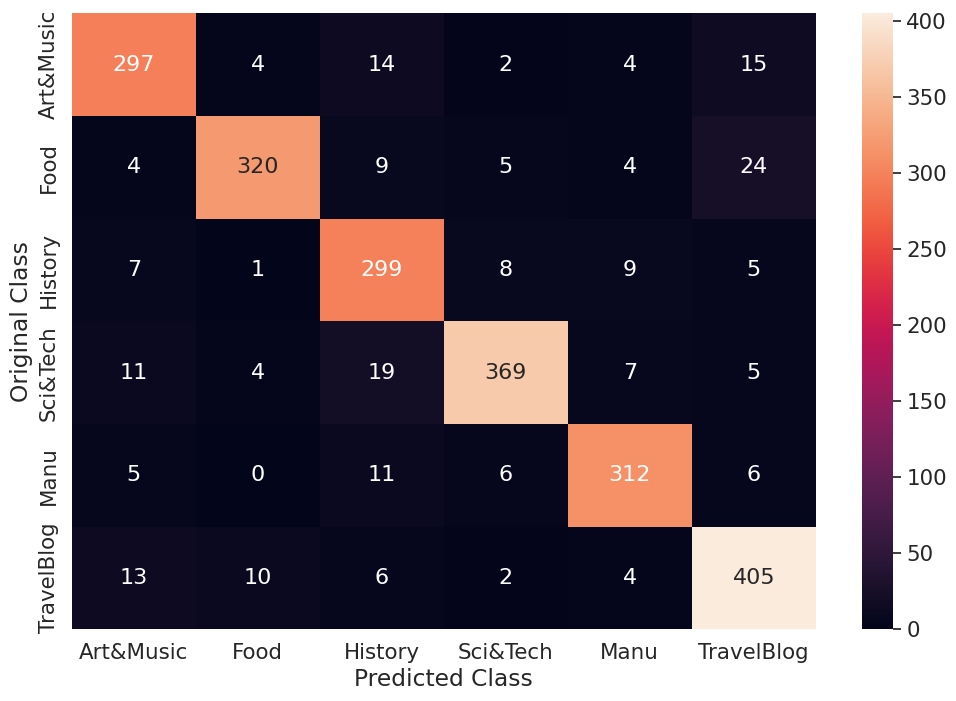

-------------------- Precision matrix --------------------


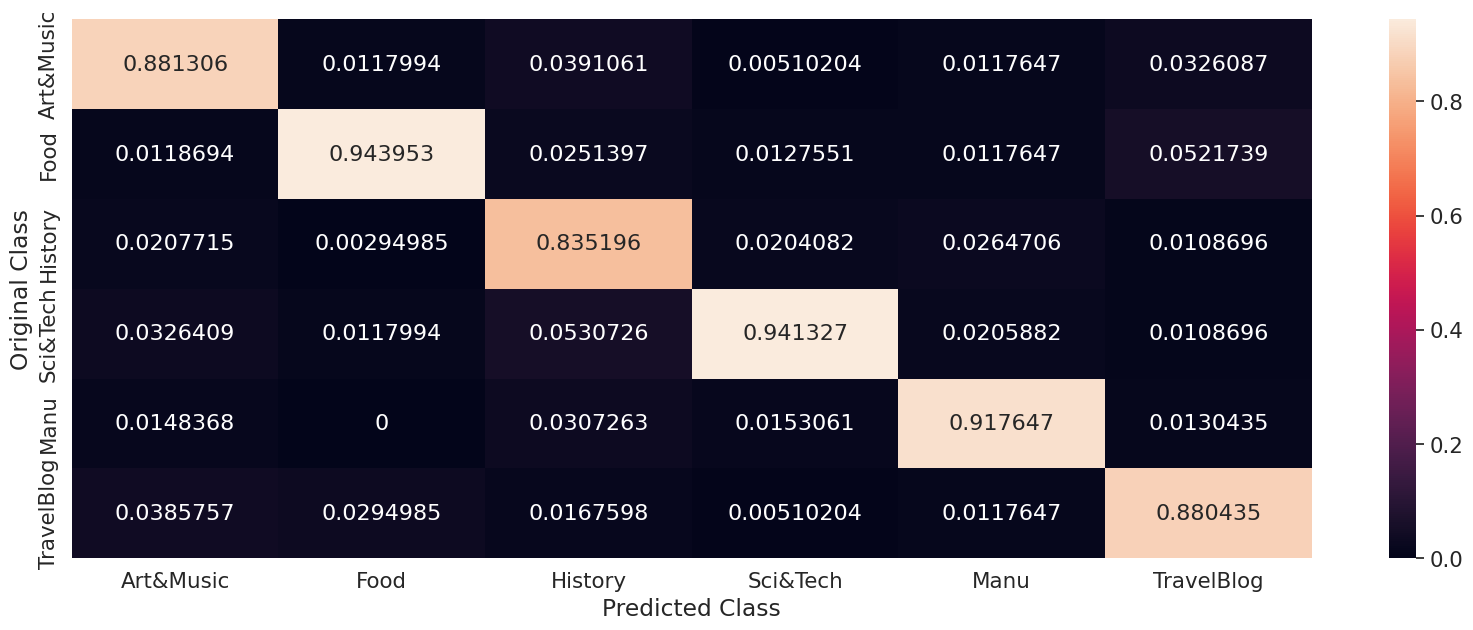

-------------------- Recall matrix --------------------


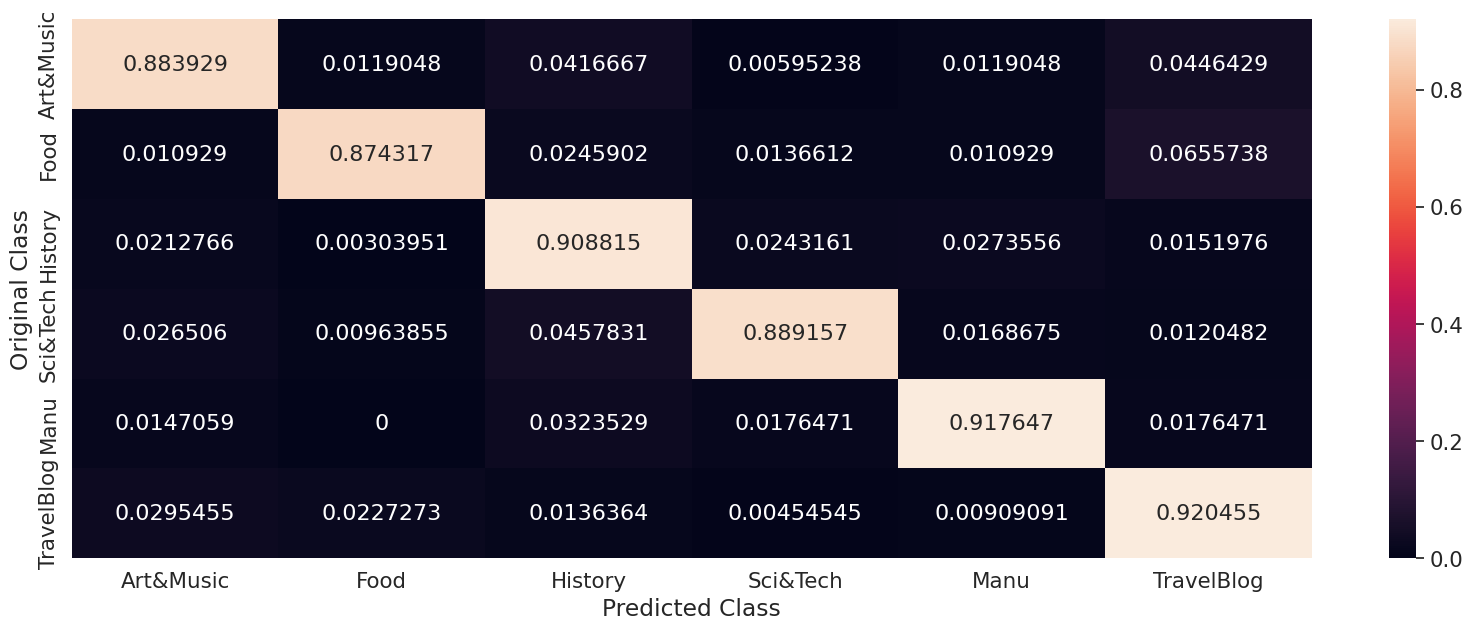

In [34]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(x_tr_uni,y_train)
y_pred = lr.predict(x_test_uni)

print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))

print("-"*20, "confusion matrix", "-"*20)
plt.figure(figsize=(12,8))
matrix=confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(matrix)
sns.set(font_scale=1.4)#for label size
labels = ['Art&Music','Food','History','Sci&Tech','Manu','TravelBlog']
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g',xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()
plotPrecisionRecall(y_test,y_pred)

TF-IDF - Logistic Regression


In [35]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
x_tr_tfidf = tf_idf_vect.fit_transform(x_tr)
x_test_tfidf = tf_idf_vect.transform(x_test)
x_cv_tfidf = tf_idf_vect.transform(x_cv)

Accuracy on test set: 91.375%
Precision on test set: 0.915
Recall on test set: 0.913
F1-Score on test set: 0.914
-------------------- confusion matrix --------------------


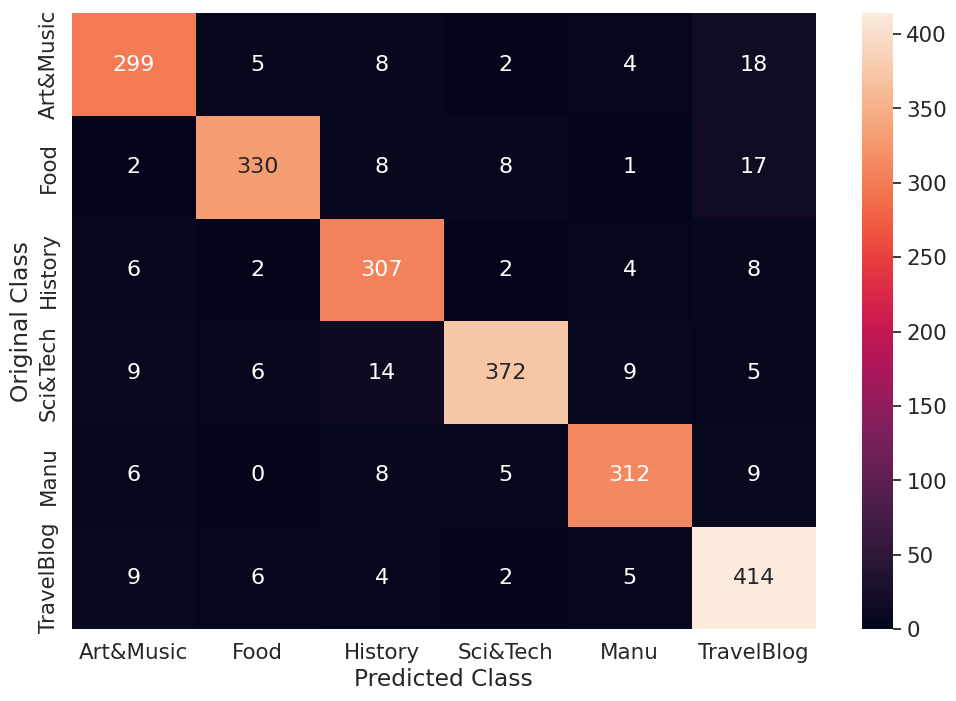

-------------------- Precision matrix --------------------


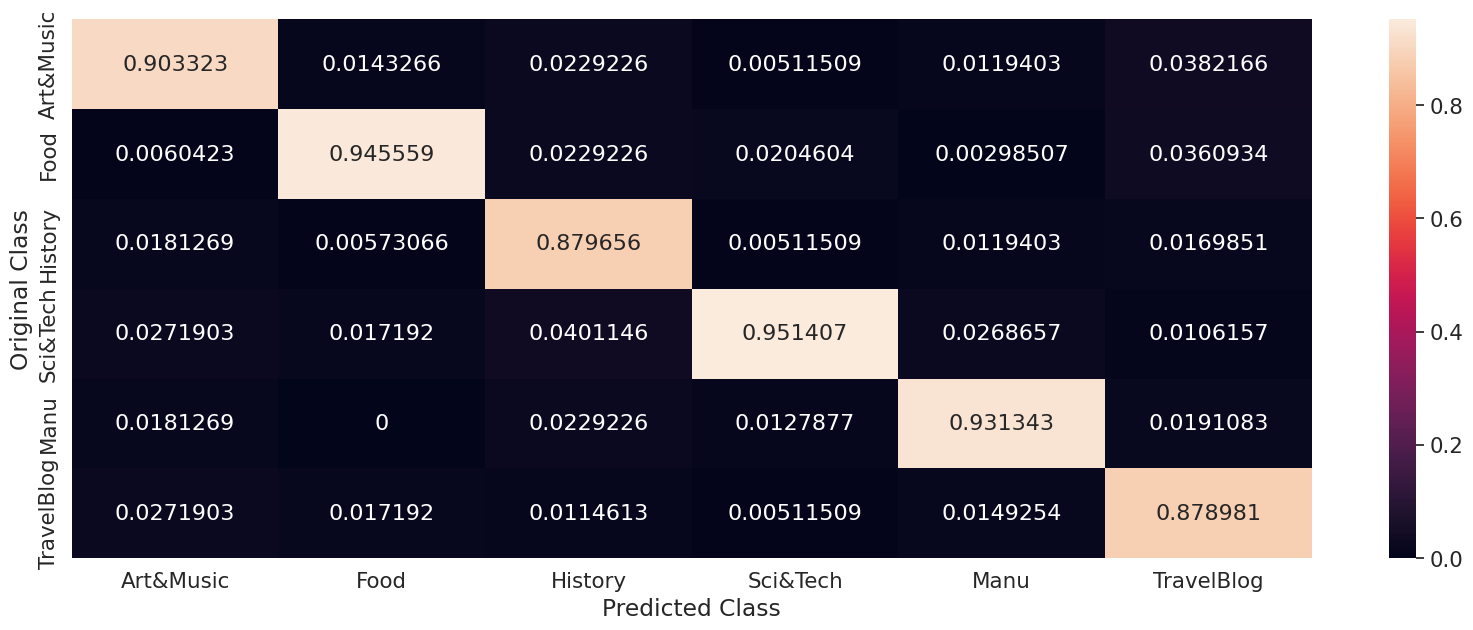

-------------------- Recall matrix --------------------


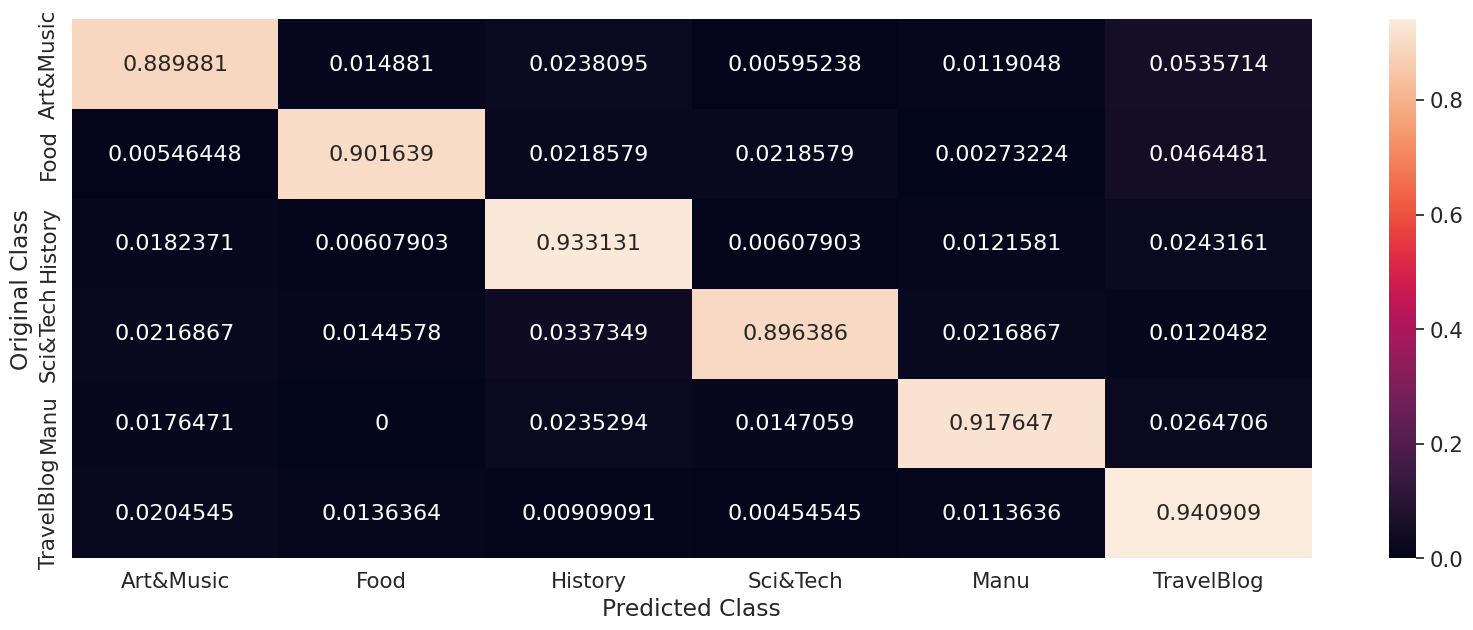

In [36]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(x_tr_tfidf,y_train)
y_pred = lr.predict(x_test_tfidf)

print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))

print("-"*20, "confusion matrix", "-"*20)
plt.figure(figsize=(12,8))
matrix=confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(matrix)
sns.set(font_scale=1.4)#for label size
labels = ['Art&Music','Food','History','Sci&Tech','Manu','TravelBlog']
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g',xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()
plotPrecisionRecall(y_test,y_pred)